In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt



In [2]:
net_sigmoid = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

net_relu = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)



In [3]:
# load dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

batch_size = 256
train_data = datasets.FashionMNIST(root=r'F:\code\AI\wx_with_ly_DeepLearning_Record\data', train=True, download=False, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root=r'F:\code\AI\wx_with_ly_DeepLearning_Record\data', train=False, download=False, transform=transforms.ToTensor())
train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
def evaluate_accuracy(net, data_iter):
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            correct += (net(X).argmax(axis=1) == y).sum().item()
            total += y.size(0)
    return correct / total
    

In [6]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)

    net.to(device)
    # 定义优化算法
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    # 记录每一轮的损失，训练集的正确率，测试集的正确率
    train_epoch_loss, train_epoch_acc, test_epoch_acc = [], [], []
    for epoch in range(num_epochs):
        train_loss = 0
        correct, total = 0, 0
        net.train()

        for X, y in train_iter:
            # t1 = time.time()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            # 此处的损失是平均损失，所以不用sum
            l = loss(y_hat, y)
            train_loss += l.item()
            l.backward()
            optimizer.step()
            # t2 = time.time()
            correct += (y_hat.argmax(axis=1) == y).sum().item()
            total += y.size(0)
        test_acc = evaluate_accuracy(net, test_iter)
        print(f'epoch {epoch + 1}, train loss {train_loss / len(train_iter)}, train acc {correct / total}, test acc {test_acc}')
        train_epoch_loss.append(train_loss / len(train_iter))
        train_epoch_acc.append(correct / total)
        test_epoch_acc.append(test_acc)

    plt.plot(range(1, num_epochs + 1), train_epoch_loss, label='Train Loss')
    plt.show()
    plt.plot(range(1, num_epochs + 1), train_epoch_acc, label='Train Acc')
    plt.plot(range(1, num_epochs + 1), test_epoch_acc, label='Test Acc')
    plt.show()

In [7]:
num_epochs = 10

training on cuda:0
epoch 1, train loss 1.0119762088390107, train acc 0.6257833333333334, test acc 0.7259
epoch 2, train loss 0.5967713428304551, train acc 0.7764833333333333, test acc 0.7855
epoch 3, train loss 0.5078449289849464, train acc 0.8116, test acc 0.8157
epoch 4, train loss 0.4606857973210355, train acc 0.8293833333333334, test acc 0.8039
epoch 5, train loss 0.43006761010656963, train acc 0.8403166666666667, test acc 0.6989
epoch 6, train loss 0.4113977821583443, train acc 0.8472666666666666, test acc 0.826
epoch 7, train loss 0.39046806312621907, train acc 0.8571666666666666, test acc 0.8336
epoch 8, train loss 0.3747408029880929, train acc 0.8630166666666667, test acc 0.842
epoch 9, train loss 0.36528610422256147, train acc 0.8659166666666667, test acc 0.8439
epoch 10, train loss 0.3520774651715096, train acc 0.8702166666666666, test acc 0.8294


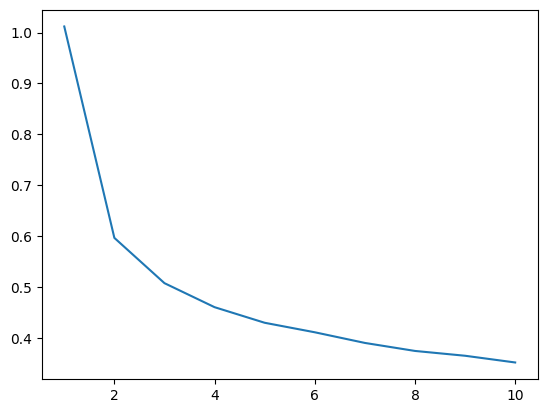

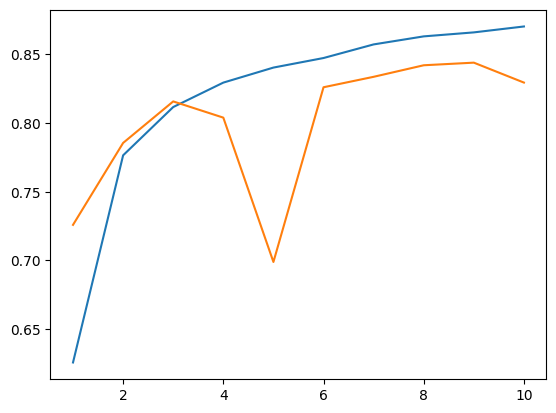

In [8]:
train(net_relu, train_iter, test_iter, num_epochs, lr=0.1, device=device)

In [13]:
net_relu_1 = nn.Sequential(
    nn.Conv2d(1, 5, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(5, 15, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(15*5*5, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)
# kernel size 不变，修改卷积的channel数改成 1映射到5，5映射到15 
# test准确率确实提高到了0.858，训练集的准确率也提高到0.87，但是不确定是否是小概率。
# 测试集和训练集效果差距有点大是否出现了过拟合？

# 第二次测试效果还有提升，但是很明显出现了过拟合，test acc 从 0.83到0.80到0.82 0.85 0.86 最后降到了0.839

# 多次测试下来发现 训练集和测试集准确率仍有明显区别，那过拟合没跑了，接下来准备缩小 kernel size

training on cuda:0
epoch 1, train loss 0.9500833460625182, train acc 0.6488, test acc 0.7704
epoch 2, train loss 0.569499142753317, train acc 0.7844666666666666, test acc 0.7861
epoch 3, train loss 0.4905545587235309, train acc 0.8170833333333334, test acc 0.7203
epoch 4, train loss 0.4477988953286029, train acc 0.8328833333333333, test acc 0.8356
epoch 5, train loss 0.4180402384159413, train acc 0.84415, test acc 0.8012
epoch 6, train loss 0.3942109980481736, train acc 0.8529333333333333, test acc 0.7871
epoch 7, train loss 0.37867157763623177, train acc 0.85855, test acc 0.852
epoch 8, train loss 0.361038986862974, train acc 0.8659333333333333, test acc 0.8436
epoch 9, train loss 0.34923467946813463, train acc 0.8692666666666666, test acc 0.8197
epoch 10, train loss 0.3363112197911486, train acc 0.8758666666666667, test acc 0.847


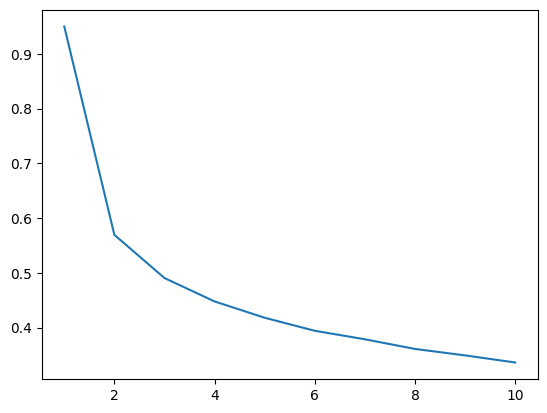

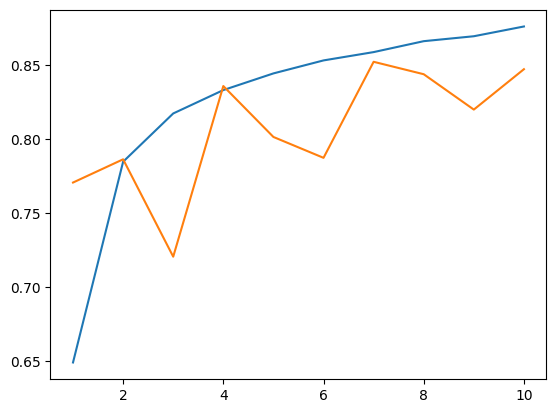

training on cuda:0
epoch 1, train loss 0.9338646181086276, train acc 0.6500833333333333, test acc 0.7398
epoch 2, train loss 0.5840644417925084, train acc 0.7788166666666667, test acc 0.7536
epoch 3, train loss 0.49228402173265495, train acc 0.8153, test acc 0.782
epoch 4, train loss 0.4497986151816997, train acc 0.83185, test acc 0.8289
epoch 5, train loss 0.41428993902307876, train acc 0.8461166666666666, test acc 0.8289
epoch 6, train loss 0.3941441650086261, train acc 0.8531666666666666, test acc 0.8365
epoch 7, train loss 0.37227813588812, train acc 0.8619666666666667, test acc 0.8233
epoch 8, train loss 0.3610176097205345, train acc 0.8655166666666667, test acc 0.8549
epoch 9, train loss 0.3471447279478641, train acc 0.8714833333333334, test acc 0.8218
epoch 10, train loss 0.3404538046806417, train acc 0.87315, test acc 0.8311


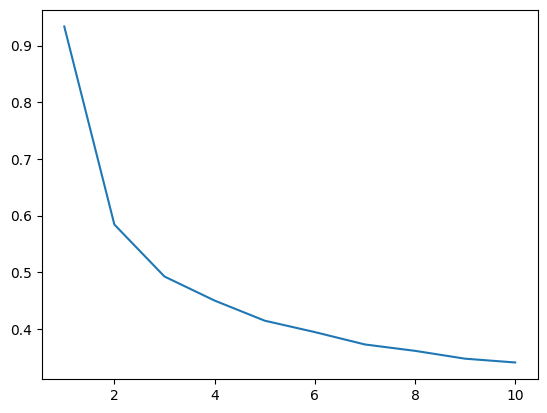

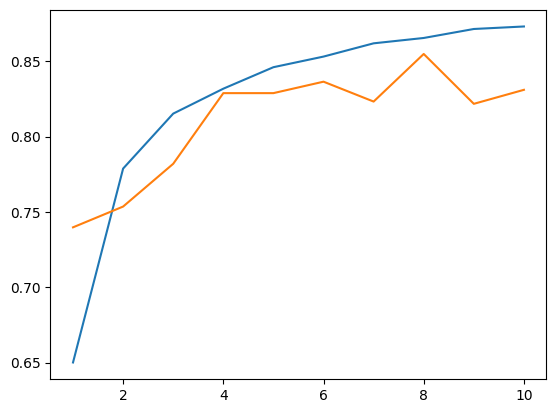

training on cuda:0
epoch 1, train loss 0.9185209089137139, train acc 0.6541166666666667, test acc 0.7295
epoch 2, train loss 0.5771838525508313, train acc 0.7798166666666667, test acc 0.7996
epoch 3, train loss 0.4889611889707281, train acc 0.8149833333333333, test acc 0.7759
epoch 4, train loss 0.4383344533595633, train acc 0.83705, test acc 0.8015
epoch 5, train loss 0.4069058167173507, train acc 0.8495833333333334, test acc 0.8303
epoch 6, train loss 0.38473479925317966, train acc 0.8571166666666666, test acc 0.8448
epoch 7, train loss 0.3646490956874604, train acc 0.86355, test acc 0.858
epoch 8, train loss 0.3491540654542598, train acc 0.87115, test acc 0.8333
epoch 9, train loss 0.3387973120237919, train acc 0.87375, test acc 0.8535
epoch 10, train loss 0.3267703501468009, train acc 0.8782166666666666, test acc 0.8681


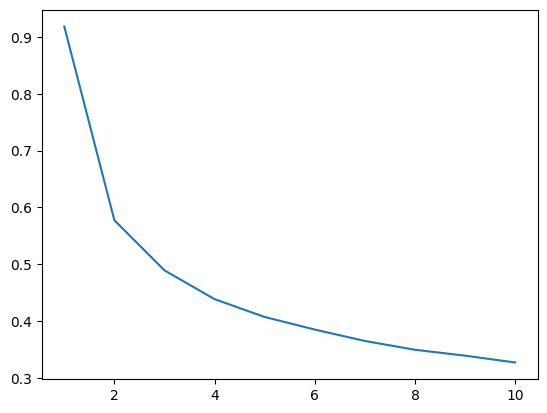

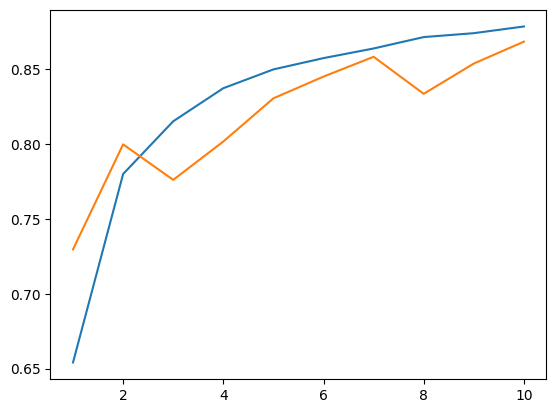

In [14]:
train(net_relu_1, train_iter, test_iter, num_epochs, lr=0.1, device=device)
train(net_relu_1, train_iter, test_iter, num_epochs, lr=0.1, device=device)
train(net_relu_1, train_iter, test_iter, num_epochs, lr=0.1, device=device)


In [24]:
net_relu_2 = nn.Sequential(
    nn.Conv2d(1, 5, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(5, 15, kernel_size=3),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(15*6*6, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)

training on cuda:0
epoch 1, train loss 0.9240777883123844, train acc 0.6508, test acc 0.7104
epoch 2, train loss 0.5604712181902947, train acc 0.7864166666666667, test acc 0.7846
epoch 3, train loss 0.47986285432856135, train acc 0.8202, test acc 0.8099
epoch 4, train loss 0.43078088963285405, train acc 0.8412333333333334, test acc 0.8285
epoch 5, train loss 0.4042550359634643, train acc 0.8507333333333333, test acc 0.8387
epoch 6, train loss 0.38386311347180224, train acc 0.8584166666666667, test acc 0.8086
epoch 7, train loss 0.3690897335397436, train acc 0.8633333333333333, test acc 0.8429
epoch 8, train loss 0.35155169913109313, train acc 0.8695833333333334, test acc 0.8571
epoch 9, train loss 0.3395564317703247, train acc 0.8736666666666667, test acc 0.8592
epoch 10, train loss 0.3333167317699879, train acc 0.8753833333333333, test acc 0.8483
epoch 11, train loss 0.3219691463607423, train acc 0.8805166666666666, test acc 0.8486
epoch 12, train loss 0.31515653069983135, train acc 0

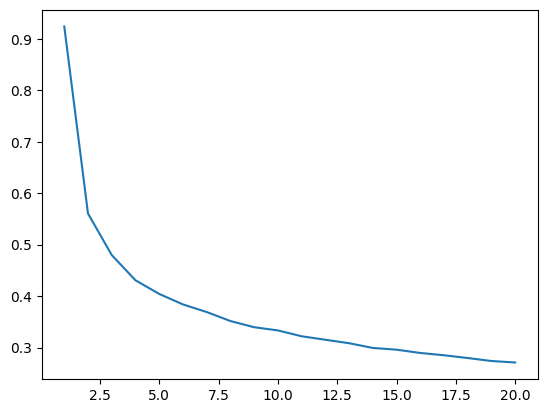

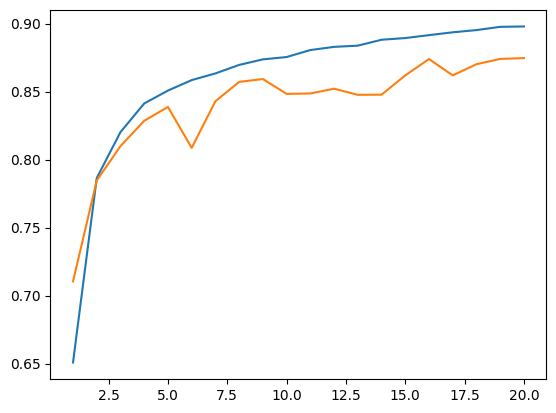

training on cuda:0
epoch 1, train loss 0.8755683830443849, train acc 0.6665166666666666, test acc 0.7191
epoch 2, train loss 0.5466827822492478, train acc 0.7907, test acc 0.782
epoch 3, train loss 0.4770136225730815, train acc 0.8215833333333333, test acc 0.812
epoch 4, train loss 0.4404772795261221, train acc 0.8346666666666667, test acc 0.7645
epoch 5, train loss 0.40916377775212553, train acc 0.8468166666666667, test acc 0.8179
epoch 6, train loss 0.3901953359233572, train acc 0.85435, test acc 0.8214
epoch 7, train loss 0.3750612750966498, train acc 0.86015, test acc 0.8322
epoch 8, train loss 0.35990898266751714, train acc 0.8655833333333334, test acc 0.8537
epoch 9, train loss 0.34631271711055267, train acc 0.8707166666666667, test acc 0.8421
epoch 10, train loss 0.3381663884254212, train acc 0.8722333333333333, test acc 0.8481
epoch 11, train loss 0.3261383115611178, train acc 0.8778833333333333, test acc 0.8632
epoch 12, train loss 0.31944382038522273, train acc 0.879516666666

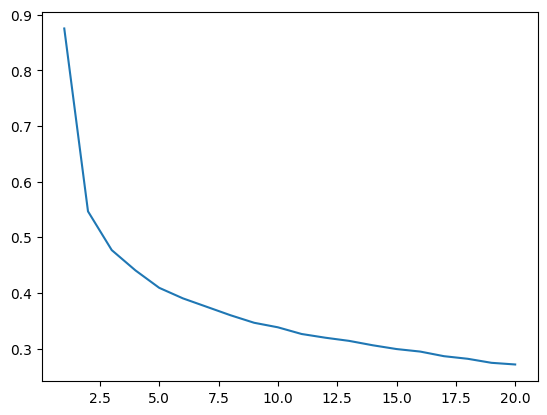

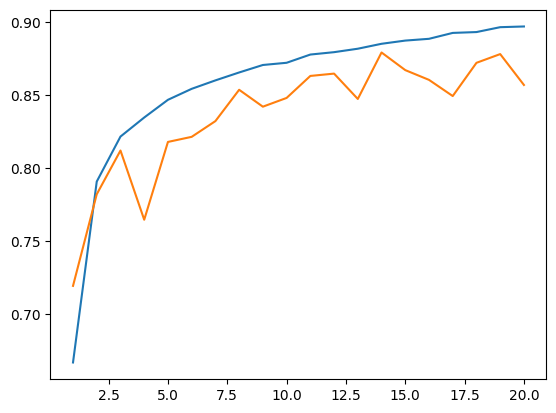

training on cuda:0
epoch 1, train loss 0.9476642310619354, train acc 0.6456333333333333, test acc 0.756
epoch 2, train loss 0.5795667766256535, train acc 0.77665, test acc 0.7852
epoch 3, train loss 0.504325845520547, train acc 0.8103, test acc 0.7356
epoch 4, train loss 0.45569957088916857, train acc 0.8308833333333333, test acc 0.8219
epoch 5, train loss 0.4233103059707804, train acc 0.8428666666666667, test acc 0.8427
epoch 6, train loss 0.3979097088600727, train acc 0.8516166666666667, test acc 0.8416
epoch 7, train loss 0.3791271048023346, train acc 0.85935, test acc 0.829
epoch 8, train loss 0.3676904133025636, train acc 0.8646333333333334, test acc 0.8561
epoch 9, train loss 0.35289868446106604, train acc 0.8696, test acc 0.8455
epoch 10, train loss 0.3399121989595129, train acc 0.8740666666666667, test acc 0.8521
epoch 11, train loss 0.32870223788504904, train acc 0.8775333333333334, test acc 0.8519
epoch 12, train loss 0.3244351666024391, train acc 0.8799166666666667, test acc

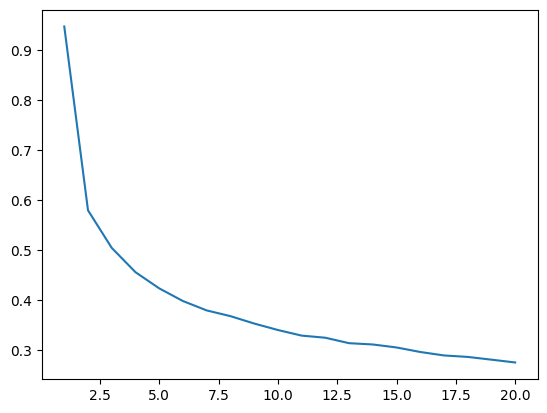

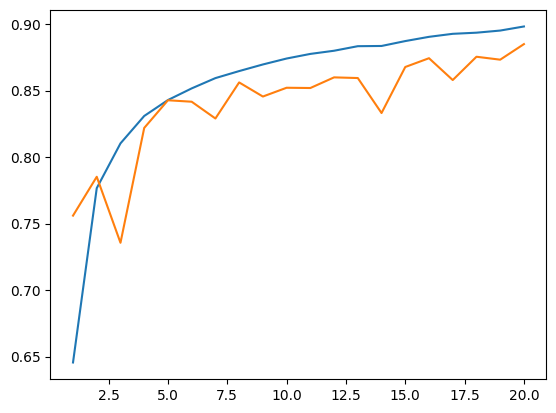

In [26]:
train(net_relu_2, train_iter, test_iter, 20, lr=0.1, device=device)
train(net_relu_2, train_iter, test_iter, 20, lr=0.12, device=device)
train(net_relu_2, train_iter, test_iter, 20, lr=0.08, device=device)

In [22]:
def comp_conv2d(conv2d, X):
    """这个函数用来告诉我们输入X 经过卷积层之后的size变化"""
    X = X.reshape((1,1)+X.shape)
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])


In [23]:
X = torch.rand(size=(28,28))
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
comp_conv2d(conv2d, X).shape

torch.Size([28, 28])

In [27]:
# 几轮测试测下来发现lr再调低一点可能会更好，但是仍然有过拟合现象，是否应该减少卷积核的输出通道数来限制
net_relu_3 = nn.Sequential(
    nn.Conv2d(1, 5, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(5, 12, kernel_size=3),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(12*6*6, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)

training on cuda:0
epoch 1, train loss 1.0662002753704152, train acc 0.61175, test acc 0.7182
epoch 2, train loss 0.6159945291407565, train acc 0.7642833333333333, test acc 0.6837
epoch 3, train loss 0.537445691925414, train acc 0.7969, test acc 0.8003
epoch 4, train loss 0.4934264057494224, train acc 0.81405, test acc 0.7736
epoch 5, train loss 0.4628526160057555, train acc 0.8266333333333333, test acc 0.7759
epoch 6, train loss 0.43059448650542725, train acc 0.8403166666666667, test acc 0.8299
epoch 7, train loss 0.41453426607111665, train acc 0.8461333333333333, test acc 0.813
epoch 8, train loss 0.3968984811864001, train acc 0.8531, test acc 0.8508
epoch 9, train loss 0.3869822476772552, train acc 0.8570666666666666, test acc 0.8293
epoch 10, train loss 0.37779911934061255, train acc 0.8604333333333334, test acc 0.8288
epoch 11, train loss 0.3666936144549796, train acc 0.8664333333333334, test acc 0.8508
epoch 12, train loss 0.3553398132958311, train acc 0.8700666666666667, test ac

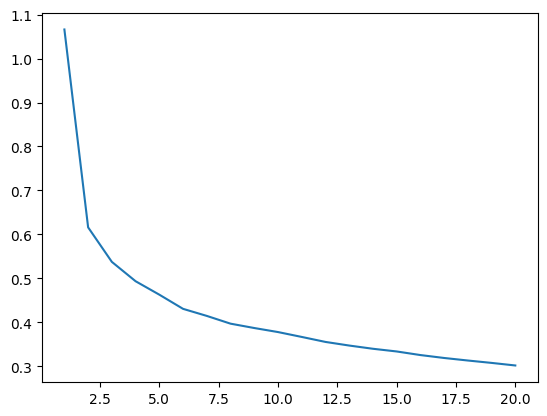

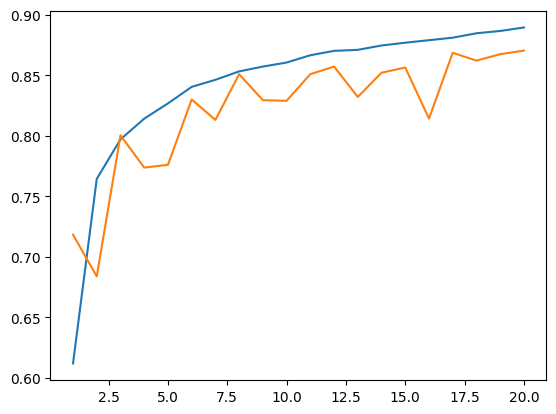

training on cuda:0
epoch 1, train loss 1.038989386152714, train acc 0.628, test acc 0.7229
epoch 2, train loss 0.6036375126940139, train acc 0.76805, test acc 0.7799
epoch 3, train loss 0.525546237382483, train acc 0.8019166666666667, test acc 0.7894
epoch 4, train loss 0.4870860565215983, train acc 0.8166666666666667, test acc 0.8086
epoch 5, train loss 0.4558586785133849, train acc 0.8312, test acc 0.82
epoch 6, train loss 0.43090723930521213, train acc 0.8402833333333334, test acc 0.8277
epoch 7, train loss 0.4105087730478733, train acc 0.8483166666666667, test acc 0.8438
epoch 8, train loss 0.3933589260628883, train acc 0.85325, test acc 0.8482
epoch 9, train loss 0.3803913389114623, train acc 0.8604333333333334, test acc 0.8096
epoch 10, train loss 0.3694812931913011, train acc 0.8634166666666667, test acc 0.8197
epoch 11, train loss 0.3613459079189503, train acc 0.8663166666666666, test acc 0.851
epoch 12, train loss 0.35275920166614205, train acc 0.8701666666666666, test acc 0.8

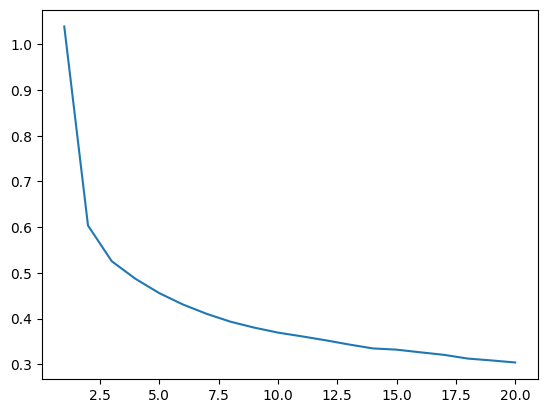

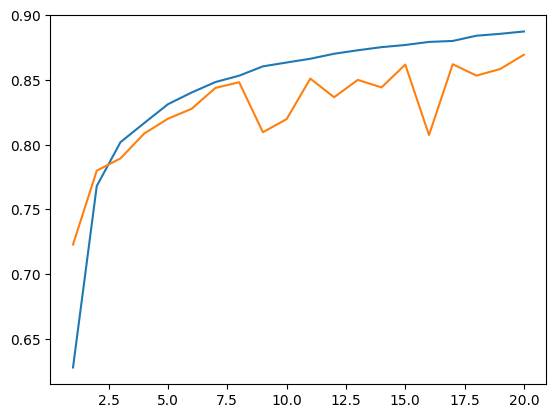

training on cuda:0
epoch 1, train loss 1.1071984965750512, train acc 0.6038666666666667, test acc 0.6919
epoch 2, train loss 0.6747402787208557, train acc 0.74055, test acc 0.7477
epoch 3, train loss 0.5991352010280528, train acc 0.77205, test acc 0.7361
epoch 4, train loss 0.5508978803107079, train acc 0.7923833333333333, test acc 0.6991
epoch 5, train loss 0.5225209747223144, train acc 0.8027333333333333, test acc 0.7603
epoch 6, train loss 0.4971346855163574, train acc 0.81355, test acc 0.8096
epoch 7, train loss 0.47959729775469356, train acc 0.8205, test acc 0.811
epoch 8, train loss 0.4604382949940702, train acc 0.8291833333333334, test acc 0.7923
epoch 9, train loss 0.44730573131683027, train acc 0.8334166666666667, test acc 0.8225
epoch 10, train loss 0.43368289166308466, train acc 0.8393166666666667, test acc 0.8166
epoch 11, train loss 0.423078705148494, train acc 0.8416, test acc 0.8258
epoch 12, train loss 0.4136291061310058, train acc 0.8468833333333333, test acc 0.8193
ep

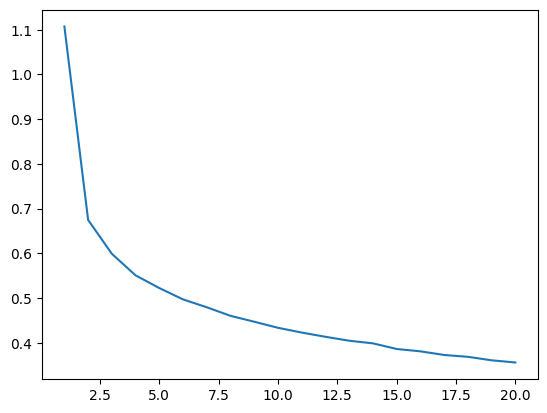

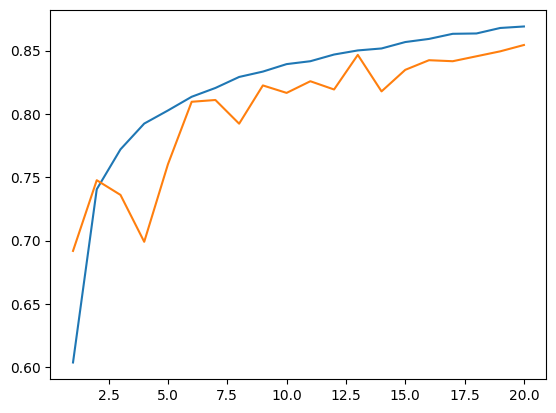

In [29]:
train(net_relu_3, train_iter, test_iter, 20, lr=0.08, device=device)
train(net_relu_3, train_iter, test_iter, 20, lr=0.06, device=device)
train(net_relu_3, train_iter, test_iter, 20, lr=0.04, device=device)

In [31]:
# 过拟合仍然存在，上一个网络选择减少第二个卷积层的输出通道数，这次打算删掉第一个卷积核通道数，lr大概在0.08
net_relu_4 = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(4, 12, kernel_size=3),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(12*6*6, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)

training on cuda:0
epoch 1, train loss 1.0692665513525619, train acc 0.6067166666666667, test acc 0.7445
epoch 2, train loss 0.6389386207499402, train acc 0.7559833333333333, test acc 0.7759
epoch 3, train loss 0.5482844848582085, train acc 0.7947833333333333, test acc 0.687
epoch 4, train loss 0.5028942049817836, train acc 0.81265, test acc 0.7946
epoch 5, train loss 0.4660612051791333, train acc 0.8276166666666667, test acc 0.825
epoch 6, train loss 0.4376657540493823, train acc 0.8392, test acc 0.8045
epoch 7, train loss 0.4196287099351274, train acc 0.8440833333333333, test acc 0.8433
epoch 8, train loss 0.401783790740561, train acc 0.8509166666666667, test acc 0.8183
epoch 9, train loss 0.3890431823882651, train acc 0.8555, test acc 0.8427
epoch 10, train loss 0.3764984585503314, train acc 0.8605166666666667, test acc 0.8484
epoch 11, train loss 0.3698887568204961, train acc 0.86325, test acc 0.8409
epoch 12, train loss 0.35928464798217125, train acc 0.86685, test acc 0.8578
epoch

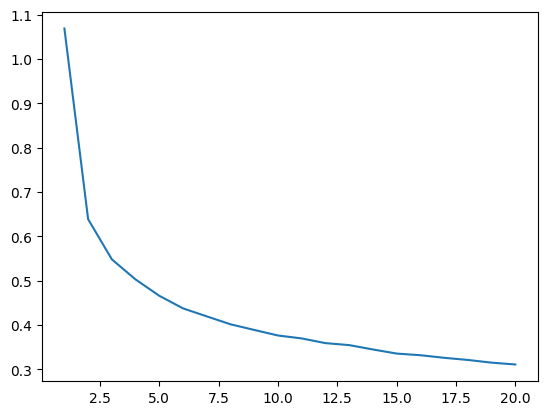

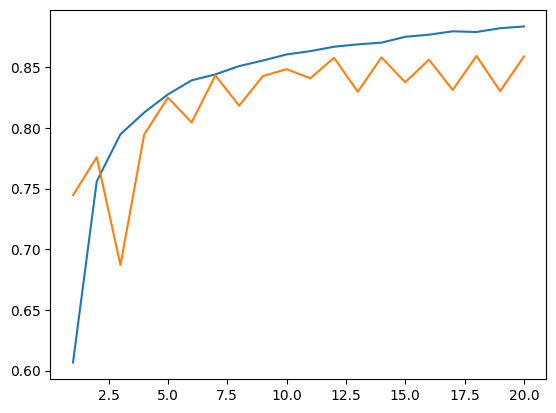

training on cuda:0
epoch 1, train loss 1.0121502315744442, train acc 0.6220333333333333, test acc 0.7211
epoch 2, train loss 0.6187409946259032, train acc 0.75885, test acc 0.7656
epoch 3, train loss 0.5442665945976338, train acc 0.7924666666666667, test acc 0.7916
epoch 4, train loss 0.49415156815914396, train acc 0.8136333333333333, test acc 0.8077
epoch 5, train loss 0.45944187476279885, train acc 0.8274333333333334, test acc 0.8043
epoch 6, train loss 0.4323288786918559, train acc 0.8394166666666667, test acc 0.8215
epoch 7, train loss 0.4129274462131744, train acc 0.8479333333333333, test acc 0.8372
epoch 8, train loss 0.39863407599165085, train acc 0.85195, test acc 0.8321
epoch 9, train loss 0.3843484846201349, train acc 0.8581333333333333, test acc 0.8345
epoch 10, train loss 0.3732284019602106, train acc 0.8612833333333333, test acc 0.8382
epoch 11, train loss 0.3593792397925194, train acc 0.8658, test acc 0.8514
epoch 12, train loss 0.3504744859451943, train acc 0.86806666666

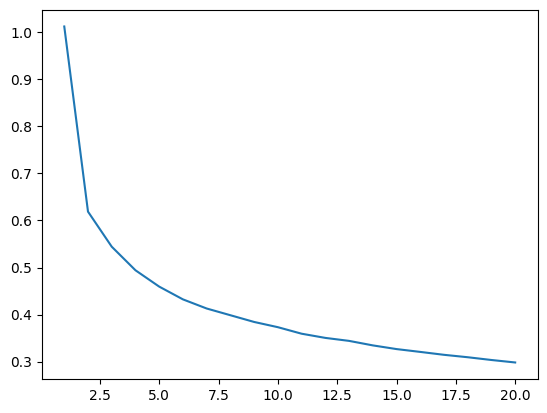

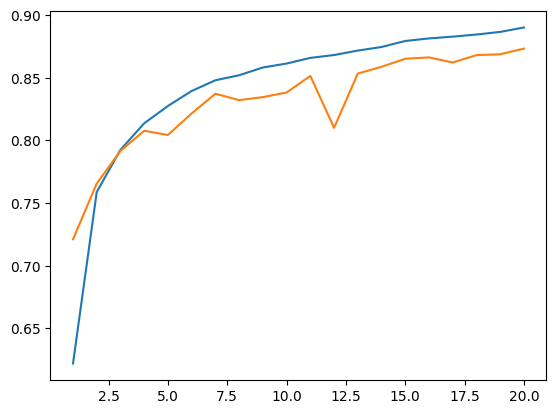

training on cuda:0
epoch 1, train loss 1.0980046898760694, train acc 0.5921666666666666, test acc 0.7657
epoch 2, train loss 0.5957364958651522, train acc 0.7721, test acc 0.6928
epoch 3, train loss 0.531116114271448, train acc 0.8001333333333334, test acc 0.7453
epoch 4, train loss 0.48917164498187127, train acc 0.8160166666666666, test acc 0.8173
epoch 5, train loss 0.45869221522452985, train acc 0.8292333333333334, test acc 0.7924
epoch 6, train loss 0.43719502332362725, train acc 0.8359166666666666, test acc 0.8306
epoch 7, train loss 0.41753420132271785, train acc 0.8433833333333334, test acc 0.8382
epoch 8, train loss 0.3986127658093229, train acc 0.85125, test acc 0.8146
epoch 9, train loss 0.38606425308166664, train acc 0.8565833333333334, test acc 0.8124
epoch 10, train loss 0.3750612971630502, train acc 0.8609833333333333, test acc 0.8392
epoch 11, train loss 0.36369947283825976, train acc 0.8659166666666667, test acc 0.8405
epoch 12, train loss 0.3543356814283006, train acc 

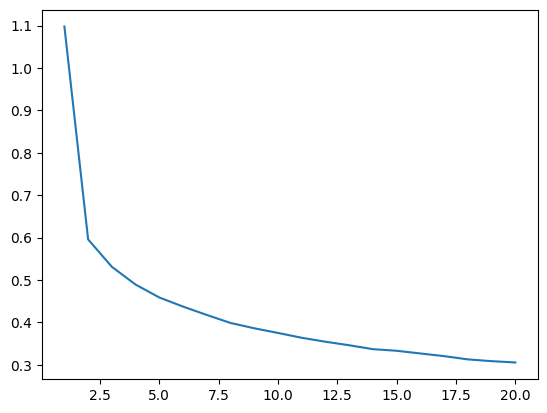

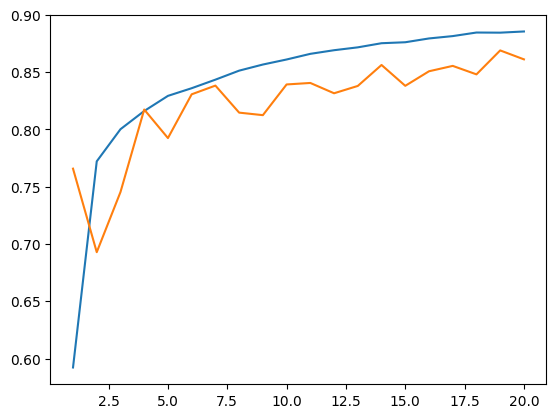

In [32]:
train(net_relu_4, train_iter, test_iter, 20, lr=0.08, device=device)
train(net_relu_4, train_iter, test_iter, 20, lr=0.08, device=device)
train(net_relu_4, train_iter, test_iter, 20, lr=0.08, device=device)

In [35]:
# 采用dropout的方法尝试解决过拟合
net_relu_5 = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(4, 12, kernel_size=3),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(12*6*6, 120),
    nn.Dropout(p=0.6),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(84, 10)
)

training on cuda:0
epoch 1, train loss 1.4469781310000318, train acc 0.453, test acc 0.6985
epoch 2, train loss 0.9224628872059761, train acc 0.6515333333333333, test acc 0.7076
epoch 3, train loss 0.8212108246823575, train acc 0.6912166666666667, test acc 0.7469
epoch 4, train loss 0.7595786178365667, train acc 0.7149666666666666, test acc 0.7688
epoch 5, train loss 0.7180634397141477, train acc 0.7354833333333334, test acc 0.7605
epoch 6, train loss 0.6789688483197638, train acc 0.7461833333333333, test acc 0.7695
epoch 7, train loss 0.6496599757924993, train acc 0.7571166666666667, test acc 0.794
epoch 8, train loss 0.6336311131081682, train acc 0.7651833333333333, test acc 0.802
epoch 9, train loss 0.6135233142274491, train acc 0.7737666666666667, test acc 0.8137
epoch 10, train loss 0.6007104860975387, train acc 0.77775, test acc 0.8125
epoch 11, train loss 0.5906781584658521, train acc 0.78425, test acc 0.8178
epoch 12, train loss 0.5752526326382413, train acc 0.79, test acc 0.82

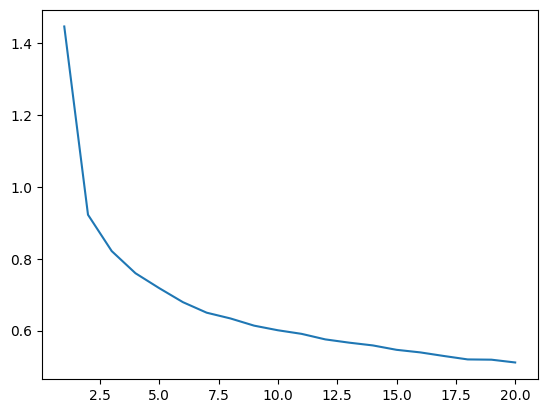

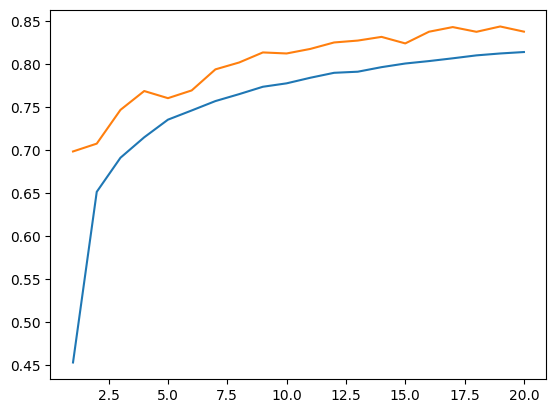

training on cuda:0
epoch 1, train loss 1.7134295220070697, train acc 0.35961666666666664, test acc 0.7064
epoch 2, train loss 0.9529087804733438, train acc 0.6458833333333334, test acc 0.7403
epoch 3, train loss 0.8184672307460866, train acc 0.6943666666666667, test acc 0.7604
epoch 4, train loss 0.745814673444058, train acc 0.7217666666666667, test acc 0.7659
epoch 5, train loss 0.702562453645341, train acc 0.7367, test acc 0.7705
epoch 6, train loss 0.6679461971242378, train acc 0.7515666666666667, test acc 0.7934
epoch 7, train loss 0.6442267244166516, train acc 0.76055, test acc 0.8024
epoch 8, train loss 0.620856906758978, train acc 0.7702166666666667, test acc 0.8074
epoch 9, train loss 0.6086229714941471, train acc 0.77745, test acc 0.8122
epoch 10, train loss 0.5899218549119666, train acc 0.7832166666666667, test acc 0.8102
epoch 11, train loss 0.5778119974947991, train acc 0.7911333333333334, test acc 0.813
epoch 12, train loss 0.5723196268081665, train acc 0.79365, test acc 0

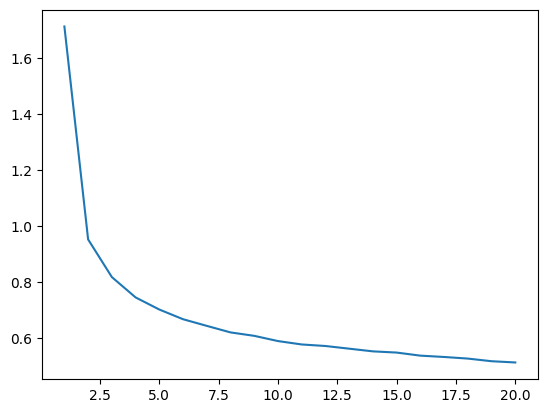

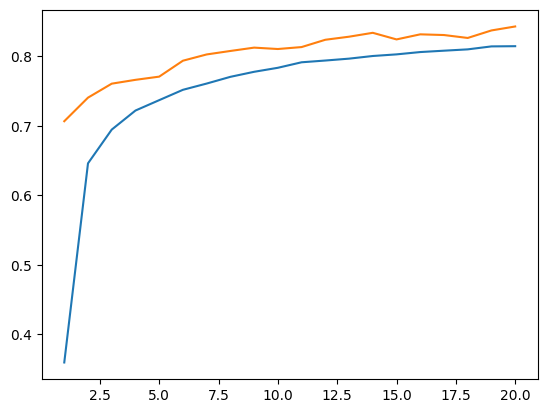

training on cuda:0
epoch 1, train loss 1.4146620707308992, train acc 0.47101666666666664, test acc 0.7136
epoch 2, train loss 0.8899386999454905, train acc 0.66575, test acc 0.7577
epoch 3, train loss 0.7881135400305403, train acc 0.70665, test acc 0.761
epoch 4, train loss 0.7196309206333567, train acc 0.7321333333333333, test acc 0.779
epoch 5, train loss 0.6805474042892456, train acc 0.7462833333333333, test acc 0.7827
epoch 6, train loss 0.6498119853912516, train acc 0.75785, test acc 0.7981
epoch 7, train loss 0.6213191585337862, train acc 0.7714333333333333, test acc 0.7976
epoch 8, train loss 0.6014530419035161, train acc 0.77945, test acc 0.8121
epoch 9, train loss 0.5894511697140146, train acc 0.78545, test acc 0.8269
epoch 10, train loss 0.5752425453764327, train acc 0.7895666666666666, test acc 0.8307
epoch 11, train loss 0.5569518072808043, train acc 0.7973333333333333, test acc 0.8309
epoch 12, train loss 0.5463358053501616, train acc 0.8027166666666666, test acc 0.8354
ep

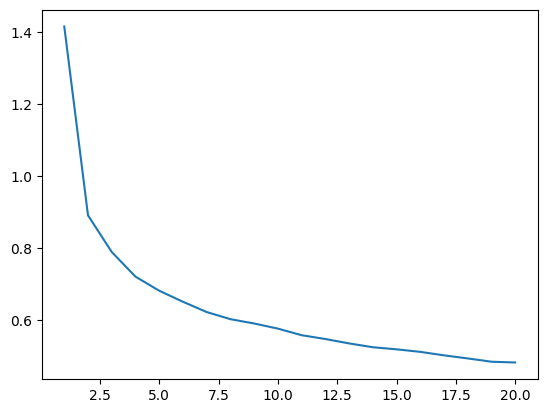

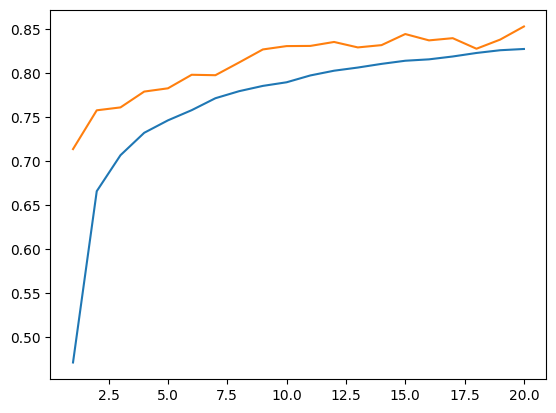

In [36]:
train(net_relu_5, train_iter, test_iter, 20, lr=0.08, device=device)
train(net_relu_5, train_iter, test_iter, 20, lr=0.08, device=device)
train(net_relu_5, train_iter, test_iter, 20, lr=0.08, device=device)